In [1]:
import torch

In [2]:
print(torch.__version__)

2.5.1


In [3]:
print("CUDA available:", torch.cuda.is_available())

CUDA available: True


In [4]:
import sys
print(sys.executable)


C:\Users\vpokh\anaconda3\envs\brain_tumor_ai\python.exe


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms
import matplotlib.pyplot as plt 
from PIL import Image
import os
from torch.utils.data import DataLoader

In [16]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [17]:
train_transform=transforms.Compose([
    transforms.Resize([224,224]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]  
    )
])

val_transform=transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]  
    )
])

In [18]:
train_dataset=datasets.ImageFolder(
    root="Downloads\mri_dataset\Training",
    transform=train_transform
)

val_dataset=datasets.ImageFolder(
    root="Downloads\mri_dataset\Testing",
    transform=val_transform
)

In [19]:
print(train_dataset.classes)

['glioma', 'meningioma', 'notumor', 'pituitary']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2565577].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2914162].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9602616].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8905448].


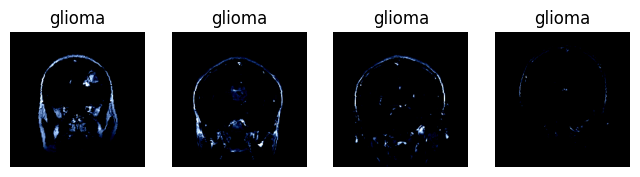

In [20]:
images, labels = next(iter(DataLoader(train_dataset, batch_size=4)))

plt.figure(figsize=(8,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(images[i].permute(1,2,0))
    plt.title(train_dataset.classes[labels[i]])
    plt.axis("off")
plt.show()


In [21]:
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=32,shuffle=False)

In [24]:
class BrainTumorCNN(nn.Module):
    def __init__(self,num_classes=4):
        super().__init__()

        self.features=nn.Sequential(
            nn.Conv2d(3,16,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16,32,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32,64,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*28*28,128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128,num_classes)
        )

    def forward(self,x):
        x=self.features(x)
        x=self.classifier(x)
        return x

In [25]:
model=BrainTumorCNN().to(device)
criterion= nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=1e-4)

In [26]:
num_epochs=10

for epoch in range(num_epochs):
    model.train()
    total_loss=0

    for images,labels in train_loader:
        images=images.to(device)
        labels=labels.to(device)

        optimizer.zero_grad()
        outputs=model(images)
        loss=criterion(outputs,labels)
        loss.backward() b
        optimizer.step()

        total_loss+=loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/10, Loss: 0.8255
Epoch 2/10, Loss: 0.6005
Epoch 3/10, Loss: 0.5246
Epoch 4/10, Loss: 0.4669
Epoch 5/10, Loss: 0.4251
Epoch 6/10, Loss: 0.3934
Epoch 7/10, Loss: 0.3667
Epoch 8/10, Loss: 0.3502
Epoch 9/10, Loss: 0.3193
Epoch 10/10, Loss: 0.2970


In [28]:
model.eval()
correct=0
total=0

with torch.no_grad():
    for images,labels in val_loader:
        images=images.to(device)
        labels=labels.to(device)
        
        outputs=model(images)
        preds=torch.argmax(outputs,dim=1)

        correct +=(preds==labels).sum().item()
        total +=labels.size(0)
accuracy=correct/total
print("Valdation Accuracy:",accuracy)

Valdation Accuracy: 0.88558352402746


In [29]:
torch.save(model.state_dict(), "brain_tumor_model.pth")


In [30]:
model=BrainTumorCNN()
model.load_state_dict(torch.load("brain_tumor_model.pth",map_location=device))
model.to(device)
model.eval()

C:\Users\vpokh\AppData\Local\Temp\ipykernel_28792\1877983409.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("brain_tumor_model.pth",map

BrainTumorCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=50176, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [99]:
def check_tumor(path):
    image=Image.open(path).convert("RGB")
    input_tensor=val_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
         output=model(input_tensor)
         probs=torch.softmax(output,dim=1)
    
    confidence,pred_idx=torch.max(probs,dim=1)   
    print("Prediction:", train_dataset.classes[pred_idx.item()])
    print("Confidence:",confidence.item())
    plt.figure(figsize=(10,5))
    plt.imshow(image)
    if train_dataset.classes[pred_idx.item()] in ['glioma', 'meningioma', 'pituitary']:
        x="positive"
    else:
        x="negative"
    plt.title(f"{x} :: {train_dataset.classes[pred_idx.item()]} :: confidence:{confidence.item() * 100:.2f}%")
    plt.axis("off")
    return plt.show()


Prediction: pituitary
Confidence: 0.9511494040489197


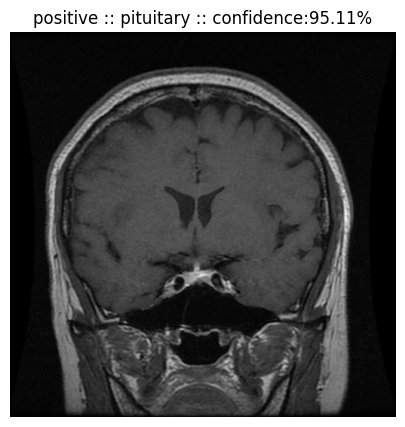

In [125]:
check_tumor("Downloads\mri_dataset\Testing\pituitary\Te-pi_0222.jpg")

Prediction: meningioma
Confidence: 0.714350700378418


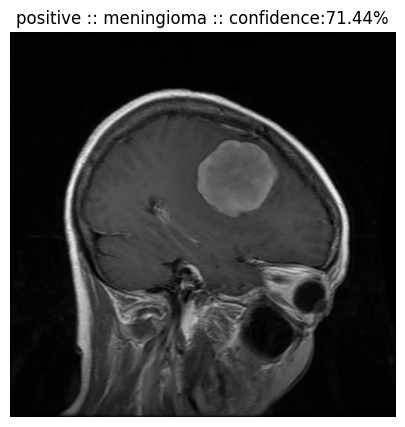

In [113]:
check_tumor("Downloads\mri_dataset\Testing\meningioma\Te-me_0274.jpg")

Prediction: notumor
Confidence: 0.9984421133995056


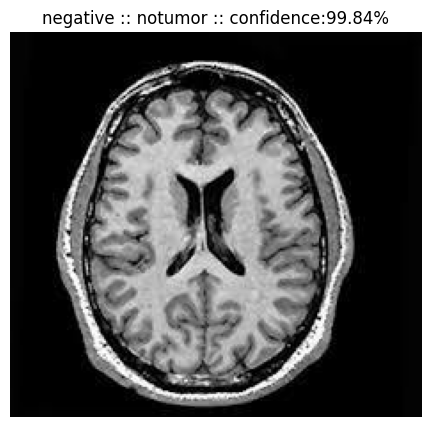

In [126]:
check_tumor(r"Downloads\mri_dataset\Testing\notumor\Te-no_0302.jpg")

Prediction: glioma
Confidence: 0.6054789423942566


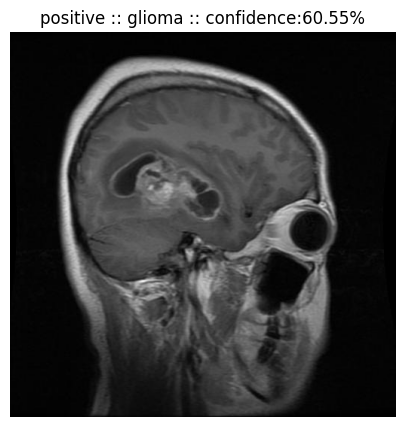

In [128]:
check_tumor("Downloads\mri_dataset\Testing\glioma\Te-gl_0282.jpg")

Prediction: notumor
Confidence: 0.7185255289077759


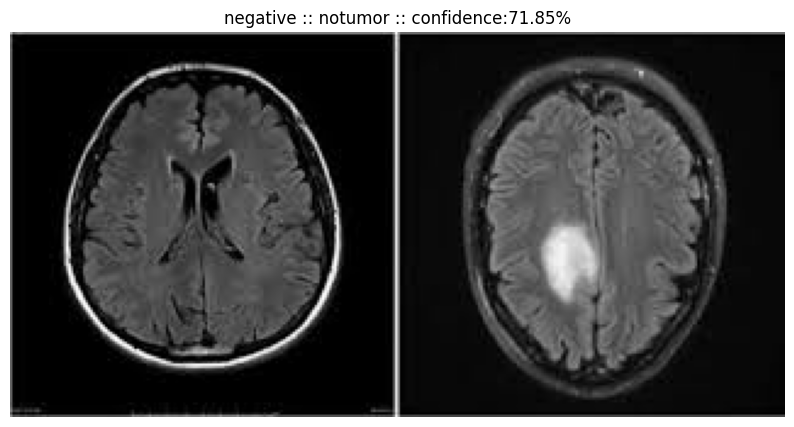

In [129]:
check_tumor(r"Desktop\x")